tgb - 4/8/2019 
- This script aims at predicting convective heating/moistening, longwave cooling, shortwave heating and microphysical tendencies based on the 8 column SPCAM simulation, with the goal of testing generalization abilities of different network architectures.  
- Notably, we would like to compare the generalization abilities of the conserving network (C), the unconstrained network (U) and the weakly-constrained network (W) with climate change (trained & validated on 0K and then statistics on the +4K simulation).  
- Another aspect is the "data greediness" of each network. Do we need less data when we train with constraints?
Notebook 009 follows the notebook 005 that predicts:
***
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX] 

## 1) Preprocess all the necessary variables

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


tgb - 4/8/2019 - We change the pre-processing configuration file "8col_rad_tbeucler_local.yml" & because we now train on the 8 column data, we change the prefix to 8col009_01_train.  
Follows the April 4th, 2019 commit of https://github.com/raspstephan/CBRAIN-CAM/blob/master/quickstart.ipynb

In [2]:
#!python preprocessing.py -c pp_config/8col_rad_tbeucler_local.yml

tgb - 4/10/2019 - Process future climate data (+4K experiment)  
tgb - 4/22/2019 - Creates 8col009_14_valid.nc with a large part of the +4K experiment

In [3]:
#!python preprocessing.py -c pp_config/8col_rad_tbeucler_p4K.yml

In [4]:
#!python preprocessing.py -c pp_config/8col_rad_tbeucler_p3K.yml

In [5]:
#!python preprocessing.py -c pp_config/8col_rad_tbeucler_p2K.yml

In [6]:
#!python preprocessing.py -c pp_config/8col_rad_tbeucler_p1K.yml

tgb - 4/24/2019 - Performances in data-scarce situations

In [8]:
!python preprocessing.py -c pp_config/8col_rad_tbeucler_ds1.yml

04/25/2019 03:11:07 AM Preprocess training dataset
04/25/2019 03:11:07 AM Start preprocessing file /local/Tom.Beucler/SPCAM_PHYS/8col009_ds1_train.nc
04/25/2019 03:11:07 AM Reading input files
04/25/2019 03:11:08 AM Crop levels
04/25/2019 03:11:08 AM Create stacked dataarray
These time steps are cut: []
04/25/2019 03:11:08 AM Stack and reshape dataarray
04/25/2019 03:11:08 AM Save dataarray as /local/Tom.Beucler/SPCAM_PHYS/8col009_ds1_train.nc
04/25/2019 03:11:21 AM Done!
04/25/2019 03:11:21 AM Shuffle training dataset
04/25/2019 03:11:21 AM Start shuffling /local/Tom.Beucler/SPCAM_PHYS/8col009_ds1_train.nc into /local/Tom.Beucler/SPCAM_PHYS/8col009_ds1_train_shuffle.nc. Open and create datasets.
04/25/2019 03:11:21 AM Shuffle!
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.59s/it]
04/25/2019 03:11:23 AM Closing datasets
04/25/2019 03:11:23 AM Done!
04/25/2019 03:11:23 AM Finish entire preprocessing script.


In [9]:
!python preprocessing.py -c pp_config/8col_rad_tbeucler_ds2.yml

04/25/2019 03:11:25 AM Preprocess training dataset
04/25/2019 03:11:25 AM Start preprocessing file /local/Tom.Beucler/SPCAM_PHYS/8col009_ds2_train.nc
04/25/2019 03:11:25 AM Reading input files
04/25/2019 03:11:32 AM Crop levels
04/25/2019 03:11:32 AM Create stacked dataarray
These time steps are cut: []
04/25/2019 03:11:33 AM Stack and reshape dataarray
04/25/2019 03:11:34 AM Save dataarray as /local/Tom.Beucler/SPCAM_PHYS/8col009_ds2_train.nc
04/25/2019 03:13:10 AM Done!
04/25/2019 03:13:10 AM Shuffle training dataset
04/25/2019 03:13:10 AM Start shuffling /local/Tom.Beucler/SPCAM_PHYS/8col009_ds2_train.nc into /local/Tom.Beucler/SPCAM_PHYS/8col009_ds2_train_shuffle.nc. Open and create datasets.
04/25/2019 03:13:10 AM Shuffle!
100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.27s/it]
04/25/2019 03:13:21 AM Closing datasets
04/25/2019 03:13:21 AM Done!
04/25/2019 03:13:21 AM Finish entire preprocessing script.


In [7]:
# %cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
# !python preprocessing.py -c pp_config/8col_rad_tbeucler_local_onefile.yml

tgb - 4/9/2019 - Follows method adapted by Stephan in his quickstart to define inputs/outputs/normalization

In [2]:
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM
# 1) Define inputs and outputs
in_vars = ['QBP', 'QCBP', 'QIBP', 'TBP', 'VBP', 
           'Qdt_adiabatic', 'QCdt_adiabatic', 'QIdt_adiabatic', 'Tdt_adiabatic', 'Vdt_adiabatic',
           'PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 
            'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']

# 2) Calculates pressure and pressure increments
# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]
dt = 30*60; # timestep

# 3) Define the scaling dictionary 
scale_dict = {
    'PHQ': L_V*dP/G, 
    'PHCLDLIQ': L_V*dP/G, 
    'PHCLDICE': L_V*dP/G, 
    'TPHYSTND': C_P*dP/G, 
    'QRL': C_P*dP/G, 
    'QRS': C_P*dP/G, 
    'DTVKE': C_P*dP/(G*dt), 
    'FSNT': 1, 
    'FSNS': 1, 
    'FLNT': 1, 
    'FLNS': 1, 
    'PRECT': RHO_L*L_V, 
    'PRECTEND': 1e-3*RHO_L*L_V, 
    'PRECST': RHO_L*L_V, 
    'PRECSTEN': 1e-3*RHO_L*L_V
}

# 4) Save dictionary as pickle file for loading in teh training script
save_pickle('./nn_config/scale_dicts/009_Wm2_scaling.pkl', scale_dict)
save_pickle('./nn_config/scale_dicts/009_Wm2_in_vars.pkl',in_vars)
save_pickle('./nn_config/scale_dicts/009_Wm2_out_vars.pkl',out_vars)
save_pickle('./nn_config/scale_dicts/009_Wm2_dP.pkl',dP)

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


## 2) Create data generator and produce data sample

In [7]:
PREFIX = '8col009_01_'
PREFIX_NORM = '8col009_01_'

In [8]:
train_gen = DataGenerator(
    data_fn = TRAINDIR+PREFIX+'train_shuffle.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX_NORM+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [9]:
X, Y = train_gen[0]; X.shape, Y.shape

((1024, 304), (1024, 218))

In [10]:
valid_gen = DataGenerator(
    data_fn = TRAINDIR+PREFIX+'valid.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX_NORM+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=False
)

In [11]:
X, Y = valid_gen[0]; X.shape, Y.shape

((1024, 304), (1024, 218))

# 3) Build neural networks

## 3.1) Conserving Network (C)

In [12]:
inpC = Input(shape=(304,))
densout = Dense(512, activation='linear')(inpC)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(214, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
surfout = SurRadLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi
)([inpC, densout])
massout = MassConsLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi
)([inpC, surfout])
enthout = EntConsLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=scale_dict['PHQ'],
    hyai=hyai, hybi=hybi
)([inpC, massout])
C_009 = tf.keras.models.Model(inpC, enthout)

Instructions for updating:
Colocations handled automatically by placer.


## 3.2) Unconstrained Network (U)

In [16]:
# Unconstrained model with 5 dense layers
inpU = Input(shape=(304,))
densout = Dense(512, activation='linear')(inpU)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out_layer = LeakyReLU(alpha=0.3)(densout)
U_009 = tf.keras.models.Model(inpU, out_layer)

## 3.3) Weakly-constrained Network (W)

In [19]:
# Weakly-constrained models with 5 dense layers
# alpha=0.01
inp001 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp001)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W001_009 = tf.keras.models.Model(inp001, out)
# alpha=0.5
inp05 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp05)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W05_009 = tf.keras.models.Model(inp05, out)
# alpha=0.99
inp099 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp099)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W099_009 = tf.keras.models.Model(inp099, out)

# 4) Compile and train the networks

## 4.1) Define losses
tgb - 4/10/2019 - Trying to solve the following error:  
  
You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,304]
	 [[{{node input_2}} = Placeholder[dtype=DT_FLOAT, shape=[?,304], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node ConstantFoldingCtrl/loss/ent_cons_layer_loss/broadcast_weights/assert_broadcastable/AssertGuard/Switch_0/_310}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_972_C...d/Switch_0", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]  
  
when trying to train several networks in a row.
tgb - 4/10/2019 - First, understand how to access normalization  
  
tgb - 4/10/2019 - Found the problem: The weak loss function tracks a given input layer, and that has to be different for each network.

In [20]:
# # 1) Open the file containing the normalization of the targets
# ds = xr.open_dataset(TRAINDIR + PREFIX + 'norm.nc')
# # 2) Open the pickle files containing the pressure converters
# with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
#             hyai, hybi = pickle.load(f)
# print(ds)
# # 3) Define input transform and save it
# inp_transform = InputNormalizer(ds, in_vars, 'mean', 'maxrs')
# print(inp_transform)
# inp_div = inp_transform.div
# inp_sub = inp_transform.sub
# norm_q=scale_dict['PHQ']
# print('inp_div.shape=',inp_div.shape)
# print('inp_sub.shape=',inp_sub.shape)
# print('hyai.shape=',hyai.shape)
# print('hybi.shape=',hybi.shape)
# print('norm_q.shape=',norm_q.shape)

# ds.close()

In [21]:
W05_loss = WeakLoss(inp05, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                     norm_q=scale_dict['PHQ'], hyai=hyai, hybi=hybi, name='W05_loss')
W001_loss = WeakLoss(inp001, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                     norm_q=scale_dict['PHQ'], hyai=hyai, hybi=hybi, alpha_mass=5e-3, alpha_ent=5e-3, name = 'W001_loss')
W099_loss = WeakLoss(inp099, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                     norm_q=scale_dict['PHQ'], hyai=hyai, hybi=hybi, alpha_mass=0.99/2, alpha_ent=0.99/2, name = 'W099_loss')
masC_loss = WeakLoss(inpC, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                      norm_q=scale_dict['PHQ'], hyai=hyai, hybi=hybi, alpha_mass=1, alpha_ent=0, name='masC_loss')
entC_loss = WeakLoss(inpC, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                     norm_q=scale_dict['PHQ'], hyai=hyai, hybi=hybi, alpha_mass=0, alpha_ent=1, name='entC_loss')
masU_loss = WeakLoss(inpU, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                      norm_q=scale_dict['PHQ'], hyai=hyai, hybi=hybi, alpha_mass=1, alpha_ent=0, name='masU_loss')
entU_loss = WeakLoss(inpU, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                     norm_q=scale_dict['PHQ'], hyai=hyai, hybi=hybi, alpha_mass=0, alpha_ent=1, name='entU_loss')

## 4.2) Compile the models

### 4.2.1) Use mean square error as loss function

In [22]:
#C_009.compile(tf.keras.optimizers.RMSprop(), loss=mse, metrics=[mse, masC_loss, entC_loss])
C_009.compile(tf.keras.optimizers.RMSprop(), loss=mse)

In [23]:
#U_009.compile(tf.keras.optimizers.RMSprop(), loss=mse, metrics=[mse, masU_loss, entU_loss])
U_009.compile(tf.keras.optimizers.RMSprop(), loss=mse)

### 4.1.2) Use custom loss function

In [24]:
W001_009.compile(tf.keras.optimizers.RMSprop(), loss=W001_loss, metrics=[mass_loss, ent_loss, mse, W001_loss])

NameError: name 'mass_loss' is not defined

In [25]:
W05_009.compile(tf.keras.optimizers.RMSprop(), loss=W05_loss, metrics=[mass_loss, ent_loss, mse, W05_loss])

NameError: name 'mass_loss' is not defined

In [26]:
W099_009.compile(tf.keras.optimizers.RMSprop(), loss=W099_loss, metrics=[mass_loss, ent_loss, mse, W099_loss])

NameError: name 'mass_loss' is not defined

## 4.3) Train the models

### 4.3.1) Train compiled models

In [27]:
# Nep = 10
# hC_009 = C_009.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen)
# hU_009 = U_009.fit_generator(train_gen, epochs=Nep, validation_data=valid_gen)

### 4.3.2) Save models in .h5 format

In [31]:
# %cd $TRAINDIR/HDF5_DATA
# !pwd
# C_009.save('C_009.h5')
# U_009.save('U_009.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


In [29]:
# W001_rad_5dens.save('W001_rad2_5dens.h5')
# W05_rad_5dens.save('W05_rad2_5dens.h5')
# W099_rad_5dens.save('W099_rad2_5dens.h5')

### 4.3.3) Load models if already trained
tgb - 2/11/2019 - OPTIONAL: Load the models if already trained.

In [2]:
%cd $TRAINDIR/HDF5_DATA
!ls
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}
C_009 = load_model('C_009.h5',custom_objects=dict_lay)
U_009 = load_model('U_009.h5',custom_objects=dict_lay)
#C_009.load_weights('C_009.h5')
#U_009.load_weights('U_009.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
C_009.h5	mdU4kstats.pkl	model2.h5  model5.h5		 test.pkl
mdC4kstats.pkl	mdUstats.pkl	model3.h5  model6.h5		 U_009.h5
mdCstats.pkl	model1.h5	model4.h5  model_cons16l256n.h5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# 5) Compare R2 plot in present and future climate
tgb - 4/10/2019 - Use the new quickstart from Stephan at https://github.com/raspstephan/CBRAIN-CAM/blob/master/quickstart.ipynb

## 5.1) Present climate

### 5.1.1) Check Stephan's workflow
tgb - 4/15/2019 - Adapt https://github.com/raspstephan/CBRAIN-CAM/blob/master/quickstart.ipynb

In [3]:
from cbrain.model_diagnostics.model_diagnostics import ModelDiagnostics

#### 5.1.1.1) Calculate statistics

In [4]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
data4k_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_02_valid.nc'
data_test = '/local/Tom.Beucler/SPCAM_PHYS/8col009_03_train.nc'
mdC = ModelDiagnostics(C_009,config_fn,data_fn)
mdU = ModelDiagnostics(U_009,config_fn,data_fn)
mdC4k = ModelDiagnostics(C_009,config_fn,data4k_fn)
mdU4k = ModelDiagnostics(U_009,config_fn,data4k_fn)

#### 5.1.1.2) Save statistics in pickle files

In [5]:
# mdC.compute_stats()
# pickle.dump(mdC.stats,open('mdCstats.pkl','wb'))

In [6]:
# mdU.compute_stats()
# pickle.dump(mdU.stats,open('mdUstats.pkl','wb'))

In [7]:
# mdU4k.compute_stats()
# pickle.dump(mdU4k.stats,open('mdU4kstats.pkl','wb'))

In [8]:
# mdC4k.compute_stats()
# pickle.dump(mdC4k.stats,open('mdC4kstats.pkl','wb'))

#### 5.1.1.3) Load statistics in pickle files

In [5]:
mdU.stats = pickle.load(open('mdUstats.pkl','rb'))
mdC.stats = pickle.load(open('mdCstats.pkl','rb'))
mdU4k.stats = pickle.load(open('mdU4kstats.pkl','rb'))
mdC4k.stats = pickle.load(open('mdC4kstats.pkl','rb'))

#### 5.1.1.4) Develop Mean Squared Error function in units $W^{2} m^{-4}$

In [10]:
MSE = mdC.mse_W2m4().mean((0,1,2))
MSE

162.0434265372766

#### 5.1.1.5) Develop energy loss function in units $W^{2} m^{-4}$

In [21]:
# import time
# for i in range (100):
#     time.sleep(60)
#     print(i)
# sess = tf.get_default_session()
# a.eval()
# sess.close()
mdU.res['mass'].mean((0,1))

array([272.09897], dtype=float32)

In [17]:
nt = mdU.valid_gen.n_batches
nt = 5
# Allocate stats arrays
entres = np.zeros((mdU.nlat, mdU.nlon, mdU.valid_gen.n_outputs))
masres = np.copy(entres)
lwres = np.copy(entres)
swres = np.copy(entres)

for itime in tqdm(range(nt)):
            inp, p = mdU.get_inp_pred(itime)  # [lat, lon, var, lev]
            # residuals
            entres = mdU.reshape_ngeo(mdU.ent_res(inp, p))
            masres = mdU.reshape_ngeo(mdU.mass_res(inp, p))
            lwres = mdU.reshape_ngeo(mdU.lw_res(inp, p))
            swres = mdU.reshape_ngeo(mdU.sw_res(inp, p))
            
mdU.res = {}
mdU.res['ent'] = entres/nt
mdU.res['mass'] = masres/nt
mdU.res['lw'] = lwres/nt
mdU.res['sw'] = swres/nt

#### 5.1.1.6) Statistics graph

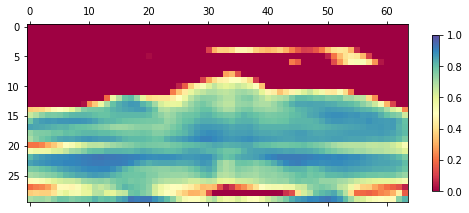

In [39]:
md1 = mdU
md2 = mdU
plt.matshow(md1.stats['r2'][:, :, md1.get_output_var_idx('QRL')].mean(1).T,
            #-\
            #md2.stats['r2'][:, :, md2.get_output_var_idx('QRL')].mean(1).T,\
            vmin=0, vmax=1, cmap='Spectral')
plt.colorbar(shrink=0.7)

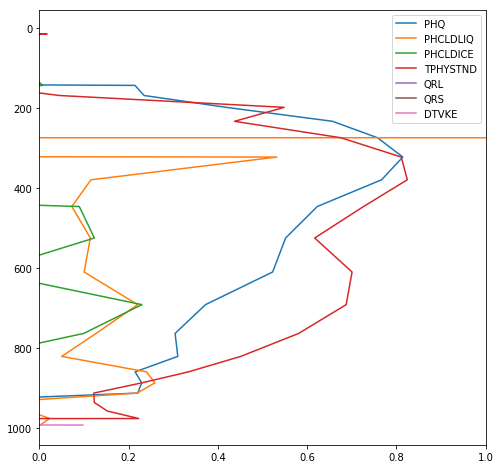

In [31]:
md = mdC4k
# Get the vertical coordinate in pressure levels
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
P = (P[1:] + P[:-1]) / 2 / 100

fig, ax = plt.subplots(figsize=(8, 8))
for v in md.valid_gen.output_vars[:7]:
    ax.plot(md.stats['hor_r2'][md.get_output_var_idx(v)], P, label=v)
ax.set_xlim(0, 1)
ax.invert_yaxis()
plt.legend()

### 5.1.2) Check performance on small subset
tgb - 4/15/2016 - Follows notebook 006 at https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/006_R2_performance.ipynb

In [112]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
latrange = coor.lat.max()-coor.lat.min(); 
lonrange = coor.lon.max()-coor.lon.min();
levrange = coor.lev.max()-coor.lev.min()
tmp = lonrange / latrange
asp = (latrange/tmp)/levrange; 

In [123]:
load_pickle('/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
load_pickle('/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_in_vars.pkl')
load_pickle('/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_out_vars.pkl')
load_pickle('/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_dP.pkl')
order_gen = DataGenerator(
    data_fn = TRAINDIR+PREFIX+'train.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=False
)
#dir(order_gen)
#vars(order_gen)

OSError: [Errno -101] NetCDF: HDF error: b'/local/Tom.Beucler/SPCAM_PHYS/8col009_01_train.nc'

In [124]:
from string import ascii_lowercase
# Labels
labels = []
for i in range(4):
    labels.append([f'{ascii_lowercase[i*2]}) CBRAIN', f'{ascii_lowercase[i*2+1]}) SP-CAM'])
# Plotting ranges
lims = {
    'TPHYSTND_NORAD': [-5e-4, 5e-4],
    'PHQ': [-2e-7, 2e-7],
    'QRL': [-1e-4, 1e-4],
    'QRS': [-1e-4, 1e-4],
    'PHCLDLIQ': [-5e-8, 5e-8],
    'PHCLDICE': [-5e-8, 5e-8],
    'TPHYSTND': [-5e-4, 5e-4],
    'DTVKE': [-5e-6, 5e-6],
}
# Full names
name = {
    'TPHYSTND_NORAD': 'Convective heating rate',
    'PHQ': 'Convective moistening rate',
    'QRL': 'Longwave heating rate',
    'QRS': 'Shortwave heating rate',
    'PHCLDLIQ': 'Convective liquid rate',
    'PHCLDICE': 'Convective ice rate',
    'TPHYSTND': 'Total heating rate',
    'DTVKE': 'Turbulent dissipation heating',
}
# Units
unit = {
    'TPHYSTND_NORAD': '[K/s]',
    'PHQ': '[kg/kg/s]',
    'QRL': '[K/s]',
    'QRS': '[K/s]',
    'PHCLDLIQ': '[kg/kg/s]',
    'PHCLDICE': '[kg/kg/s]',
    'TPHYSTND': '[K/s]',
    'DTVKE': '[K/s]',
}

In [125]:
# 1) Initialize array of zeros (Nout=218,Nt=429,Nlat=64,Nlon=128)
Nout = 218; Nt = 400; Nlat = 64; Nlon = 128; Nlev = 30;
print('Initializing arrays of zeros')
Truth = np.zeros(shape=(Nout,Nt,Nlat))
Truth = np.repeat(Truth[:,:,:,np.newaxis], Nlon, axis=3)
pred_C = np.zeros(shape=(Nout,Nt,Nlat))
pred_C = np.repeat(pred_C[:,:,:,np.newaxis], Nlon, axis=3)
pred_U = np.zeros(shape=(Nout,Nt,Nlat))
pred_U = np.repeat(pred_U[:,:,:,np.newaxis], Nlon, axis=3)
# 2) Fill up the array with truth and prediction
for it in range (Nt):
    print('it = ',it,'/',Nt-1,end="\r")
    x, y = order_gen[it];
    Truth[:,it,:,:] = np.reshape(np.transpose(y),((Nout,Nlat,Nlon)));
    pred_C[:,it,:,:] = np.reshape(np.transpose(C_009.predict_on_batch(x)),((Nout,Nlat,Nlon)));
    pred_U[:,it,:,:] = np.reshape(np.transpose(U_009.predict_on_batch(x)),((Nout,Nlat,Nlon)));

Initializing arrays of zeros


In [126]:
# Calculate lat/lon-averaged statistics
for index in range (2): 
    if index==0: PRED = pred_U;
    elif index==1: PRED = pred_C;
    Nvar = 4;
    maskC = 5e-4; # Mask regions where the variance is smaller than the mean variance by a factor maskC

    option = 1; # [1] to plot CV/RAD [2] to plot microphysics/turb
    if option==1: vars = ['TPHYSTND_NORAD', 'PHQ', 'QRL', 'QRS'];
    elif option==2: vars = ['PHCLDLIQ','PHCLDICE','TPHYSTND','DTVKE'];

    sse = np.zeros(shape=(Nvar,Nlev))
    tvar = np.zeros(shape=(Nvar,Nlev))
    mask = np.zeros(shape=(Nvar,Nlev))
    TRU = Truth;
    dP_DIV = dP.reshape(30,1,1,1)
    ilev = np.arange(0,30,1)
    for i, v in enumerate(vars):
        print(i,v)

        if option==1:
            if i==0: 
                pred = (PRED[90+ilev,:,:,:]-PRED[120+ilev,:,:,:]-PRED[150+ilev,:,:,:])/(C_P*dP_DIV/G);
                tru = (TRU[90+ilev,:,:,:]-TRU[120+ilev,:,:,:]-TRU[150+ilev,:,:,:])/(C_P*dP_DIV/G);
            elif i==1: pred = PRED[ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==2: pred = PRED[120+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[120+ilev,:,:,:]/(C_P*dP_DIV/G);
            elif i==3: pred = PRED[150+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[150+ilev,:,:,:]/(C_P*dP_DIV/G);
        elif option==2:
            if i==0: pred = PRED[30+ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[30+ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==1: pred = PRED[60+ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[60+ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==2: pred = PRED[90+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[90+ilev,:,:,:]/(C_P*dP_DIV/G);
            elif i==3: pred = PRED[180+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[180+ilev,:,:,:]/(C_P*dP_DIV/G);

        sse[i,:] = np.mean(abs(pred-tru)**2,axis=(1,2,3));
        tvar[i,:] = np.mean(abs(tru-np.mean(tru,axis=(1,2,3)).reshape(tru.shape[0],1,1,1))**2,axis=(1,2,3));
        mask[i,:] = tvar[i,:]<maskC*tvar[i,:].mean(axis=(0))

    mask = mask.astype(int); # Convert mask to integer array
    if index==0: r2U = 1-sse/tvar;
    elif index==1: r2C = 1-sse/tvar

0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


In [127]:
def despine(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


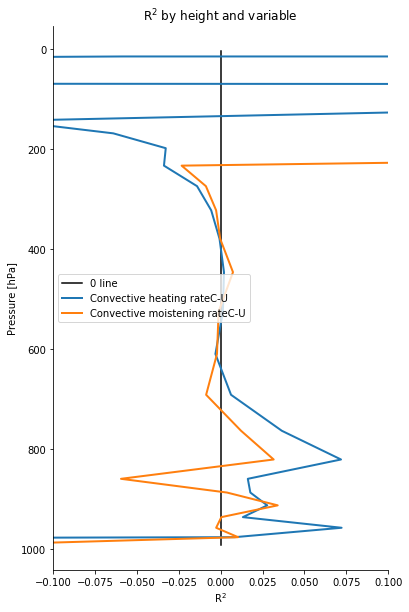

In [128]:
fig, ax = plt.subplots(figsize=(6,10))
ax.plot(0*r2C[1,:]**0, coor.lev, color='k', label='0 line')
for i, v in enumerate(['TPHYSTND_NORAD', 'PHQ']):
    #ax.plot(r2C[i,:], coor.lev, label=name[v]+'C', linewidth=2)
    #ax.plot(r2U[i,:], coor.lev, label=name[v]+'U', linewidth=2,linestyle='dashed')
    ax.plot(r2C[i,:]-r2U[i,:],coor.lev,label=name[v]+'C-U',linewidth=2)
ax.invert_yaxis()
ax.set_ylabel('Pressure [hPa]'); ax.set_xlabel(r'R$^2$')
ax.set_xlim(-0.1, 0.1)
ax.set_title(r'R$^2$ by height and variable')
despine(ax)
L = ax.legend(); L._loc=6;

In [129]:
# Calculate lat/lon-averaged statistics
for index in range (2): 
    if index==0: PRED = pred_U;
    elif index==1: PRED = pred_C;
    Nvar = 4;
    maskC = 5e-4; # Mask regions where the variance is smaller than the mean variance by a factor maskC

    option = 1; # [1] to plot CV/RAD [2] to plot microphysics/turb
    if option==1: vars = ['TPHYSTND_NORAD', 'PHQ', 'QRL', 'QRS'];
    elif option==2: vars = ['PHCLDLIQ','PHCLDICE','TPHYSTND','DTVKE'];

    sse = np.zeros(shape=(Nvar,Nlev,Nlat))
    tvar = np.zeros(shape=(Nvar,Nlev,Nlat))
    mask = np.zeros(shape=(Nvar,Nlev,Nlat))

    TRU = Truth;
    dP_DIV = dP.reshape(30,1,1,1)
    ilev = np.arange(0,30,1)
    for i, v in enumerate(vars):
        print(i,v)

        if option==1:
            if i==0: 
                pred = (PRED[90+ilev,:,:,:]-PRED[120+ilev,:,:,:]-PRED[150+ilev,:,:,:])/(C_P*dP_DIV/G);
                tru = (TRU[90+ilev,:,:,:]-TRU[120+ilev,:,:,:]-TRU[150+ilev,:,:,:])/(C_P*dP_DIV/G);
            elif i==1: pred = PRED[ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==2: pred = PRED[120+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[120+ilev,:,:,:]/(C_P*dP_DIV/G);
            elif i==3: pred = PRED[150+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[150+ilev,:,:,:]/(C_P*dP_DIV/G);
        elif option==2:
            if i==0: pred = PRED[30+ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[30+ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==1: pred = PRED[60+ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[60+ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==2: pred = PRED[90+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[90+ilev,:,:,:]/(C_P*dP_DIV/G);
            elif i==3: pred = PRED[180+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[180+ilev,:,:,:]/(C_P*dP_DIV/G);

        sse[i,:,:] = np.mean(abs(pred-tru)**2,axis=(1,3));
        tvar[i,:,:] = np.mean(abs(tru-np.mean(tru,axis=(1,3)).reshape(tru.shape[0],1,tru.shape[2],1))**2,axis=(1,3));
        mask[i,:,:] = tvar[i,:,:]<maskC*np.mean(tvar[i,:,:],axis=1).reshape(1,tvar.shape[1],1)

    mask = mask.astype(int); # Convert mask to integer array

    if index==0: r2U = 1-sse/tvar;
    elif index==1: r2C = 1-sse/tvar

0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


In [130]:
from matplotlib import patches, patheffects
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='white'), patheffects.Normal()])
    
def plot_4stats(ivar, stat, title='', vmult=1, only_pos=False, func=None, mylims=None, rows=2,
                letter_offset=0, masks=None, extend='both', **kwargs):
    fig, axes = plt.subplots(rows, 2, figsize=(16, 2 * rows))
    axes = np.atleast_2d(axes)
    plt.subplots_adjust(wspace=0.0, hspace=0.)
    for i, (ax, v) in enumerate(zip(axes.flat, vars)):
        print('i=',i,'(ax,v)=',(ax,v),'func=',func,'stat=',stat)
        if func:
            a = func(d, v)
        else:
            if stat=='r2': a = r2[i,:,:];
            elif stat=='tvar': a = tvar[i,:,:]
            elif stat=='r2C': a = r2C[i,:,:]
            elif stat=='r2U': a = r2U[i,:,:]
            elif stat=='r2CmU': a = r2C[i,:,:]-r2U[i,:,:]
        if mylims is None: 
            vmin = 0 if only_pos else lims[v][0]*vmult
            vmax = lims[v][1]*vmult
        else:
            vmin = mylims[0]; vmax = mylims[1]

        if masks is not None: a[masks[i,:,:]==1] = np.nan

        I = ax.pcolormesh(coor.lat, coor.lev, a, vmin=vmin, vmax=vmax, **kwargs)
        txt = ax.text(0.01, 0.90, f'{ascii_lowercase[i+letter_offset]}) {name[v]}', 
                      transform=ax.transAxes, fontsize=12)
        draw_outline(txt, 2)
        cb = fig.colorbar(I, ax=ax, orientation='vertical', shrink=0.8, pad=0.02, 
                          extend=extend)
        cb.set_label(unit[v])
        cb.formatter.set_powerlimits((-1, 1))
        cb.ax.yaxis.set_offset_position('left') 
        cb.update_ticks()
        
    [ax.set_ylabel('Pressure [hPa]') for ax in axes[:,0].flat]
    [ax.set_yticks([]) for ax in axes[:,1].flat]
    [ax.invert_yaxis() for ax in axes.flat]
    if rows > 1: [ax.set_xticks([]) for ax in axes[0].flat]
    [ax.set_xlabel('Latitude') for ax in axes[-1].flat]
    [ax.set_aspect(asp) for ax in axes.flat];
    fig.suptitle(title, fontsize=14, x=0.47,y=0.93)
    return fig

i= 0 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x154688928f98>, 'TPHYSTND_NORAD') func= None stat= r2U
i= 1 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x1546881cce80>, 'PHQ') func= None stat= r2U
i= 2 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x15468813c438>, 'QRL') func= None stat= r2U
i= 3 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x1546882079b0>, 'QRS') func= None stat= r2U


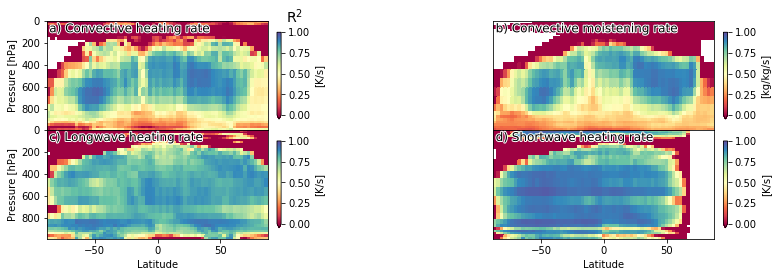

In [134]:
ivar = 0;
f = plot_4stats(ivar, 'r2U', r'R$^2$', cmap='Spectral', mylims=[0, 1], only_pos=True,
                masks=mask, extend='min')

## 5.2) Future climate

### 5.2.1) Build generator using +4K dataset

In [83]:
PREFIX4K = '8col009_02_'
order_gen_p4k = DataGenerator(
    data_fn = TRAINDIR+PREFIX4K+'valid.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+PREFIX+'norm.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=8192,
    shuffle=False
)

In [97]:
# 1) Initialize array of zeros (Nout=218,Nt=429,Nlat=64,Nlon=128)
Nout = 218; Nt = 400; Nlat = 64; Nlon = 128; Nlev = 30;
print('Initializing arrays of zeros')
Truth = np.zeros(shape=(Nout,Nt,Nlat))
Truth = np.repeat(Truth[:,:,:,np.newaxis], Nlon, axis=3)
pred_C = np.zeros(shape=(Nout,Nt,Nlat))
pred_C = np.repeat(pred_C[:,:,:,np.newaxis], Nlon, axis=3)
pred_U = np.zeros(shape=(Nout,Nt,Nlat))
pred_U = np.repeat(pred_U[:,:,:,np.newaxis], Nlon, axis=3)
# 2) Fill up the array with truth and prediction
for it in range (Nt):
    print('it = ',it,'/',Nt-1,end="\r")
    x, y = order_gen_p4k[it];
    Truth[:,it,:,:] = np.reshape(np.transpose(y),((Nout,Nlat,Nlon)));
    pred_C[:,it,:,:] = np.reshape(np.transpose(C_009.predict_on_batch(x)),((Nout,Nlat,Nlon)));
    pred_U[:,it,:,:] = np.reshape(np.transpose(U_009.predict_on_batch(x)),((Nout,Nlat,Nlon)));

Initializing arrays of zeros


In [98]:
# Calculate lat/lon-averaged statistics
for index in range (2): 
    if index==0: PRED = pred_U;
    elif index==1: PRED = pred_C;
    Nvar = 4;
    maskC = 5e-4; # Mask regions where the variance is smaller than the mean variance by a factor maskC

    option = 1; # [1] to plot CV/RAD [2] to plot microphysics/turb
    if option==1: vars = ['TPHYSTND_NORAD', 'PHQ', 'QRL', 'QRS'];
    elif option==2: vars = ['PHCLDLIQ','PHCLDICE','TPHYSTND','DTVKE'];

    sse = np.zeros(shape=(Nvar,Nlev))
    tvar = np.zeros(shape=(Nvar,Nlev))
    mask = np.zeros(shape=(Nvar,Nlev))
    TRU = Truth;
    dP_DIV = dP.reshape(30,1,1,1)
    ilev = np.arange(0,30,1)
    for i, v in enumerate(vars):
        print(i,v)

        if option==1:
            if i==0: 
                pred = (PRED[90+ilev,:,:,:]-PRED[120+ilev,:,:,:]-PRED[150+ilev,:,:,:])/(C_P*dP_DIV/G);
                tru = (TRU[90+ilev,:,:,:]-TRU[120+ilev,:,:,:]-TRU[150+ilev,:,:,:])/(C_P*dP_DIV/G);
            elif i==1: pred = PRED[ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==2: pred = PRED[120+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[120+ilev,:,:,:]/(C_P*dP_DIV/G);
            elif i==3: pred = PRED[150+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[150+ilev,:,:,:]/(C_P*dP_DIV/G);
        elif option==2:
            if i==0: pred = PRED[30+ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[30+ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==1: pred = PRED[60+ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[60+ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==2: pred = PRED[90+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[90+ilev,:,:,:]/(C_P*dP_DIV/G);
            elif i==3: pred = PRED[180+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[180+ilev,:,:,:]/(C_P*dP_DIV/G);

        sse[i,:] = np.mean(abs(pred-tru)**2,axis=(1,2,3));
        tvar[i,:] = np.mean(abs(tru-np.mean(tru,axis=(1,2,3)).reshape(tru.shape[0],1,1,1))**2,axis=(1,2,3));
        mask[i,:] = tvar[i,:]<maskC*tvar[i,:].mean(axis=(0))

    mask = mask.astype(int); # Convert mask to integer array
    if index==0: r2U = 1-sse/tvar;
    elif index==1: r2C = 1-sse/tvar

0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


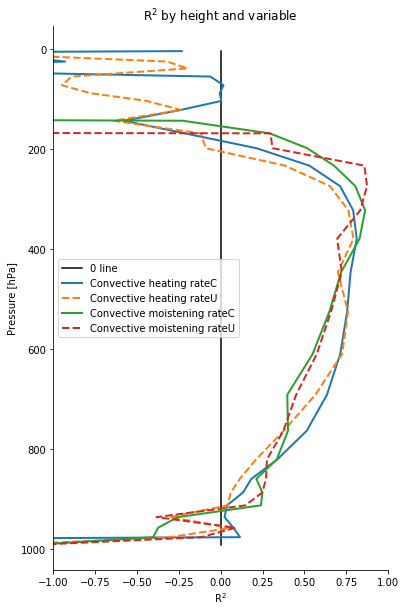

In [102]:
fig, ax = plt.subplots(figsize=(6,10))
ax.plot(0*r2C[1,:]**0, coor.lev, color='k', label='0 line')
for i, v in enumerate(['TPHYSTND_NORAD', 'PHQ']):
    ax.plot(r2C[i,:], coor.lev, label=name[v]+'C', linewidth=2)
    ax.plot(r2U[i,:], coor.lev, label=name[v]+'U', linewidth=2,linestyle='dashed')
    #ax.plot(r2C[i,:]-r2U[i,:],coor.lev,label=name[v]+'C-U',linewidth=2)
ax.invert_yaxis()
ax.set_ylabel('Pressure [hPa]'); ax.set_xlabel(r'R$^2$')
ax.set_xlim(-1, 1)
ax.set_title(r'R$^2$ by height and variable')
despine(ax)
L = ax.legend(); L._loc=6;

In [114]:
# Calculate lat/lon-averaged statistics
for index in range (2): 
    if index==0: PRED = pred_U;
    elif index==1: PRED = pred_C;
    Nvar = 4;
    maskC = 5e-4; # Mask regions where the variance is smaller than the mean variance by a factor maskC

    option = 1; # [1] to plot CV/RAD [2] to plot microphysics/turb
    if option==1: vars = ['TPHYSTND_NORAD', 'PHQ', 'QRL', 'QRS'];
    elif option==2: vars = ['PHCLDLIQ','PHCLDICE','TPHYSTND','DTVKE'];

    sse = np.zeros(shape=(Nvar,Nlev,Nlat))
    tvar = np.zeros(shape=(Nvar,Nlev,Nlat))
    mask = np.zeros(shape=(Nvar,Nlev,Nlat))

    TRU = Truth;
    dP_DIV = dP.reshape(30,1,1,1)
    ilev = np.arange(0,30,1)
    for i, v in enumerate(vars):
        print(i,v)

        if option==1:
            if i==0: 
                pred = (PRED[90+ilev,:,:,:]-PRED[120+ilev,:,:,:]-PRED[150+ilev,:,:,:])/(C_P*dP_DIV/G);
                tru = (TRU[90+ilev,:,:,:]-TRU[120+ilev,:,:,:]-TRU[150+ilev,:,:,:])/(C_P*dP_DIV/G);
            elif i==1: pred = PRED[ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==2: pred = PRED[120+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[120+ilev,:,:,:]/(C_P*dP_DIV/G);
            elif i==3: pred = PRED[150+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[150+ilev,:,:,:]/(C_P*dP_DIV/G);
        elif option==2:
            if i==0: pred = PRED[30+ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[30+ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==1: pred = PRED[60+ilev,:,:,:]/(L_V*dP_DIV/G); tru = TRU[60+ilev,:,:,:]/(L_V*dP_DIV/G);
            elif i==2: pred = PRED[90+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[90+ilev,:,:,:]/(C_P*dP_DIV/G);
            elif i==3: pred = PRED[180+ilev,:,:,:]/(C_P*dP_DIV/G); tru = TRU[180+ilev,:,:,:]/(C_P*dP_DIV/G);

        sse[i,:,:] = np.mean(abs(pred-tru)**2,axis=(1,3));
        tvar[i,:,:] = np.mean(abs(tru-np.mean(tru,axis=(1,3)).reshape(tru.shape[0],1,tru.shape[2],1))**2,axis=(1,3));
        mask[i,:,:] = tvar[i,:,:]<maskC*np.mean(tvar[i,:,:],axis=1).reshape(1,tvar.shape[1],1)

    mask = mask.astype(int); # Convert mask to integer array

    if index==0: r2U = 1-sse/tvar;
    elif index==1: r2C = 1-sse/tvar

0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


0 TPHYSTND_NORAD
1 PHQ
2 QRL
3 QRS


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide


In [118]:
from matplotlib import patches, patheffects
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='white'), patheffects.Normal()])
    
def plot_4stats(ivar, stat, title='', vmult=1, only_pos=False, func=None, mylims=None, rows=2,
                letter_offset=0, masks=None, extend='both', **kwargs):
    fig, axes = plt.subplots(rows, 2, figsize=(16, 2 * rows))
    axes = np.atleast_2d(axes)
    plt.subplots_adjust(wspace=0.0, hspace=0.)
    for i, (ax, v) in enumerate(zip(axes.flat, vars)):
        print('i=',i,'(ax,v)=',(ax,v),'func=',func,'stat=',stat)
        if func:
            a = func(d, v)
        else:
            if stat=='r2': a = r2[i,:,:];
            elif stat=='tvar': a = tvar[i,:,:]
            elif stat=='r2C': a = r2C[i,:,:]
            elif stat=='r2U': a = r2U[i,:,:]
            elif stat=='r2CmU': a = r2C[i,:,:]-r2U[i,:,:]
        if mylims is None: 
            vmin = 0 if only_pos else lims[v][0]*vmult
            vmax = lims[v][1]*vmult
        else:
            vmin = mylims[0]; vmax = mylims[1]

        if masks is not None: a[masks[i,:,:]==1] = np.nan

        I = ax.pcolormesh(coor.lat, coor.lev, a, vmin=vmin, vmax=vmax, **kwargs)
        txt = ax.text(0.01, 0.90, f'{ascii_lowercase[i+letter_offset]}) {name[v]}', 
                      transform=ax.transAxes, fontsize=12)
        draw_outline(txt, 2)
        cb = fig.colorbar(I, ax=ax, orientation='vertical', shrink=0.8, pad=0.02, 
                          extend=extend)
        cb.set_label(unit[v])
        cb.formatter.set_powerlimits((-1, 1))
        cb.ax.yaxis.set_offset_position('left') 
        cb.update_ticks()
        
    [ax.set_ylabel('Pressure [hPa]') for ax in axes[:,0].flat]
    [ax.set_yticks([]) for ax in axes[:,1].flat]
    [ax.invert_yaxis() for ax in axes.flat]
    if rows > 1: [ax.set_xticks([]) for ax in axes[0].flat]
    [ax.set_xlabel('Latitude') for ax in axes[-1].flat]
    [ax.set_aspect(asp) for ax in axes.flat];
    fig.suptitle(title, fontsize=14, x=0.47,y=0.93)
    return fig

i= 0 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x154688088ba8>, 'TPHYSTND_NORAD') func= None stat= r2CmU
i= 1 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x1546884ad2b0>, 'PHQ') func= None stat= r2CmU
i= 2 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x1546882e9550>, 'QRL') func= None stat= r2CmU
i= 3 (ax,v)= (<matplotlib.axes._subplots.AxesSubplot object at 0x15468831db38>, 'QRS') func= None stat= r2CmU


/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in subtract


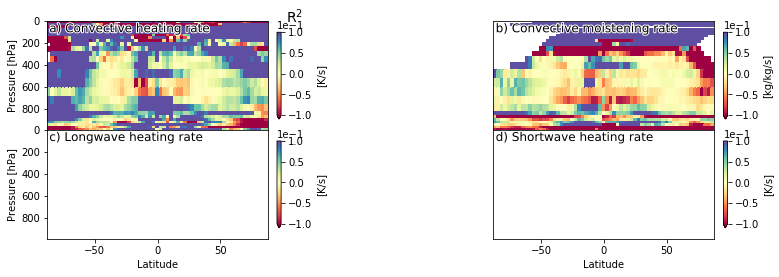

In [122]:
ivar = 0;
f = plot_4stats(ivar, 'r2CmU', r'R$^2$', cmap='Spectral', mylims=[-0.1, 0.1], only_pos=True,
                masks=mask, extend='min')